<a href="https://colab.research.google.com/github/fbeilstein/dbms/blob/master/DB_lecture_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**File Formats**

With the basic semantics of B-Trees covered, we are now ready to explore how exactly B-Trees and other structures are implemented on disk. 

We access the disk in a way that is different from how we access main memory: from an application developer’s perspective, memory accesses are mostly transparent. Because of virtual memory, we do not have to manage offsets manually. 

Disks are accessed using system calls. We usually have to
specify the offset inside the target file, and then interpret on-disk representation into a form suitable for main memory.


This means that efficient on-disk structures have to be designed with this distinction in mind. To do that, we have to come up with a file format that’s easy to construct, modify, and interpret. 

The semantics of pointer management in on-disk structures are somewhat different
from in-memory ones. It is useful to think of on-disk B-Trees as a page management mechanism: algorithms have to compose and navigate pages. Pages and pointers to them have to be calculated and placed accordingly.

Since most of the complexity in B-Trees comes from mutability, we discuss details of page layouts, splitting, relocations, and other concepts applicable to mutable data structures.

**Motivation**


Creating a file format is in many ways similar to how we create data structures in languages with an unmanaged memory model. We allocate a block of data and slice it any way we like, using fixed-size primitives and structures. If we want to reference a larger chunk of memory or a structure with variable size, we use pointers.


Languages with an unmanaged memory model allow us to allocate more memory
any time we need (within reasonable bounds) without us having to think or worry
about whether or not there’s a contiguous memory segment available, whether or not it is fragmented, or what happens after we free it. **On disk**, we have to take care of garbage collection and fragmentation ourselves.


**Data layout** is much less important in memory than on disk. For a disk-resident data structure to be efficient, we need to lay out data on disk in ways that allow quick access to it, and consider the specifics of a persistent storage medium, come up with binary data formats, and find a means to serialize and deserialize data efficiently.



Anyone who has ever used a low-level language such as C without additional libraries knows the constraints. Structures have a predefined size and are allocated and freed explicitly. Manually implementing memory allocation and tracking is even more challenging, since it is only possible to operate with memory segments of predefined size, and it is necessary to track which segments are already released and which ones are still in use.


When storing data in main memory, most of the problems with memory layout do
not exist, are easier to solve, or can be solved using third-party libraries. For example, handling variable-length fields and oversize data is much more straightforward, since we can use memory allocation and pointers, and do not need to lay them out in any special way. 


There still are cases when developers design specialized main memory
data layouts to take advantage of CPU cache lines, prefetching, and other hardwarerelated specifics, but this is mainly done for optimization purposes.
Even though the operating system and filesystem take over some of the responsibilities, implementing on-disk structures requires attention to more details and has more pitfalls.

**Binary Encoding**

To store data on disk efficiently, it needs to be encoded using a format that is compact and easy to serialize and deserialize. When talking about binary formats, you hear the word layout quite often. Since we **do not have primitives such as malloc and free**, but only read and write, we have to think of accesses differently and prepare data accordingly.


**Primitive Types**

Keys and values have a type, such as integer, date, or string, and can be represented (serialized to and deserialized from) in their raw binary forms.

Most numeric data types are represented as fixed-size values. When working with
multibyte numeric values, it is important to use the same byte-order (endianness) for both encoding and decoding. Endianness determines the sequential order of bytes:
* **Big-endian** The order starts from the most-significant byte (MSB), followed by the bytes in decreasing significance order.
* **Little-endian** The order starts from the least-significant byte (LSB), followed by the bytes in increasing significance order.

0xAABBCCDD

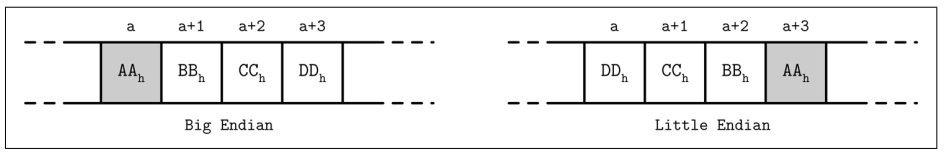

For example, to reconstruct a 64-bit integer with a corresponding byte order,
RocksDB has platform-specific definitions that help to identify target platform byte order. If the target platform endianness does not match value endianness, it reverses the bytes.


Records consist of primitives like numbers, strings, booleans, and their combinations. However, when transferring data over the network or storing it on disk, we can only use **byte sequences**. This means that, in order to send or write the record, we have to **serialize** it (convert it to an interpretable sequence of bytes) and, before we can use it after receiving or reading, we have to **deserialize** it (translate the sequence of bytes back to the original record).


In binary data formats, we always start with primitives that serve as building blocks for more complex structures. Different numeric types may vary in size. **byte** value is 8 bits, **short** is 2 bytes (16 bits), **int** is 4 bytes (32 bits), and **long** is 8 bytes (64 bits).


**Floating-point numbers** (such as float and double) are represented by their sign, fraction, and exponent. The IEEE Standard for Binary Floating-Point Arithmetic (IEEE 754) standard describes widely accepted floating-point number representation.

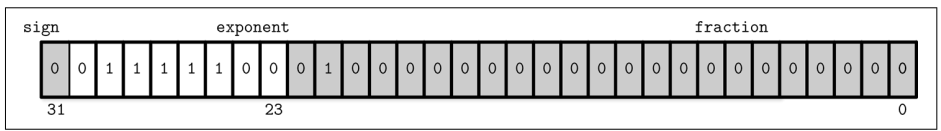

[Fast inverse square root](https://en.wikipedia.org/wiki/Fast_inverse_square_root#Overview_of_the_code)

**Strings and Variable-Size Data**


All primitive numeric types have a fixed size. Composing more complex values
together is much like struct in C. You can combine primitive values into structures and use fixed-size arrays or pointers to other memory regions.

Strings and other variable-size data types (such as arrays of fixed-size data) can be serialized as a number, representing the length of the array or string, followed by size bytes: the actual data. For strings, this representation is often called **UCSD** String or **Pascal** String, named after the popular implementation of the Pascal programming language. We can express it in pseudocode as follows:
```
String
{
  size uint_16
  data byte[size]
}
```
An alternative to Pascal strings is **null-terminated** strings, where the reader consumes the string byte-wise until the end-of-string symbol is reached.

The Pascal string approach has several advantages: it allows finding out a length of a string in constant time, instead of iterating through string contents, and a language-specific string can be composed by slicing size bytes from memory and passing the byte array to a string constructor.

**Bit-Packed Data: Booleans, Enums, and Flags**


Booleans can be represented either by using a single byte, or encoding true and
false as 1 and 0 values. Since a boolean has only two values, using an entire byte for its representation is wasteful, and developers often batch boolean values together in groups of eight, each boolean occupying just one bit. We say that every 1 bit is set and every 0 bit is unset or empty.


Enums, short for enumerated types, can be represented as integers and are often used in binary formats and communication protocols. Enums are used to represent oftenrepeated low-cardinality values. For example, we can encode a B-Tree node type using an enum:
```
enum NodeType {
  ROOT, // 0x00h
  INTERNAL, // 0x01h
  LEAF // 0x02h
};
```
Another closely related concept is **flags**, kind of a combination of packed booleans and enums. Flags can represent nonmutually exclusive named boolean parameters.

For example, we can use flags to denote whether or not the page holds value cells, whether the values are fixed-size or variable-size, and whether or not there are overflow pages associated with this node. Since every bit represents a flag value, we can only use power-of-two values for masks (since powers of two in binary always have a single set bit; for example, $2^3 = 8 = 1000_b$, $2^4 = 16 = 0001 0000_b$, etc.):
```
int IS_LEAF_MASK = 0x01h; // bit #1
int VARIABLE_SIZE_VALUES = 0x02h; // bit #2
int HAS_OVERFLOW_PAGES = 0x04h; // bit #3
```
Just like packed booleans, flag values can be read and written from the packed value using bitmasks and bitwise operators. For example, in order to set a bit responsible for one of the flags, we can use bitwise OR (|) and a bitmask. 

Instead of a bitmask, we can use bitshift (<<) and a bit index. To unset the bit, we can use bitwise AND (&) and the bitwise negation operator (~). To test whether or not the bit n is set, we can compare the result of a bitwise AND with 0:
```
// Set the bit
flags |= HAS_OVERFLOW_PAGES;
flags |= (1 << 2);
// Unset the bit
flags &= ~HAS_OVERFLOW_PAGES;
flags &= ~(1 << 2);
// Test whether or not the bit is set
is_set = (flags & HAS_OVERFLOW_PAGES) != 0;
is_set = (flags & (1 << 2)) != 0;
```

**General Principles**


Usually, you start designing a file format by deciding how the addressing is going to be done: whether the file is going to be split into same-sized pages, which are represented by a single block or multiple contiguous blocks.

Most in-place update storage structures use pages of the same size, since it significantly simplifies read and write access. 

Append-only storage structures often write data page-wise, too: records are
appended one after the other and, as soon as the page fills up in memory, it is flushed on disk.

The file usually starts with a fixed-size header and may end with a fixed-size trailer, which hold auxiliary information that should be accessed quickly or is required for decoding the rest of the file. The rest of the file is split into pages.

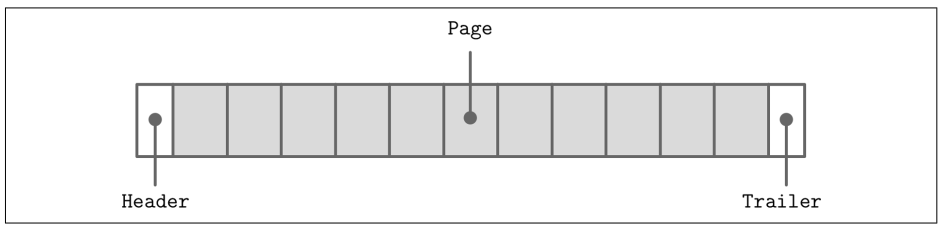

Many data stores have a fixed schema, specifying the number, order, and type of fields the table can hold. Having a fixed schema helps to reduce the amount of data stored on disk: instead of repeatedly writing field names, we can use their positional identifiers.


If we wanted to design a format for the company directory, storing names, birth
dates, tax numbers, and genders for each employee, we could use several approaches. We could store the fixed-size fields (such as birth date and tax number) in the head of the structure, followed by the variable-size ones:

**Fixed-size fields:**
```
| (4 bytes) employee_id |
| (4 bytes) tax_number |
| (3 bytes) date |
| (1 byte) gender |
| (2 bytes) first_name_length |
| (2 bytes) last_name_length |
```
**Variable-size fields:**
```
| (first_name_length bytes) first_name |
| (last_name_length bytes) last_name |
```
Now, to access `first_name`, we can slice `first_name_length` bytes after the fixed-size area. To access `last_name`, we can locate its starting position by checking the sizes of the variable-size fields that precede it. To avoid calculations involving multiple fields, we can encode both offset and length to the fixed-size area. In this case, we can locate any variable-size field separately.

Building more complex structures usually involves building hierarchies: fields composed out of primitives, cells composed of fields, pages composed of cells, sections composed of pages, regions composed of sections, and so on. 

There are no strict rules you have to follow here, and it all depends on what kind of data you need to create a format for. Database files often consist of multiple parts, with a lookup table aiding navigation and pointing to the start offsets of these parts written either in the file header, trailer, or in the separate file.

**Page Structure**


Database systems store data records in data and index files. These files are partitioned into fixed-size units called pages, which often have a size of multiple filesystem blocks. Page sizes usually range from 4 to 16 Kb. 


Let’s take a look at the example of an on-disk B-Tree node. From a structure perspective, in B-Trees, we distinguish between the leaf nodes that hold keys and data records pairs, and nonleaf nodes that hold keys and pointers to other nodes. Each B-Tree node occupies one page or multiple pages linked together, so in the context of B-Trees the terms node and page (and even block) are often used interchangeably. [The original B-Tree paper](https://infolab.usc.edu/csci585/Spring2010/den_ar/indexing.pdf) describes a simple page organization for fixedsize data records, where each page is just a concatenation of triplets (picture below, behold, it's B-tree, not $B^+$-tree).


This approach is easy to follow, but has some downsides:
* Appending a key anywhere but the right side requires relocating elements.
* It doesn’t allow managing or accessing variable-size records efficiently and works only for fixed-size data.

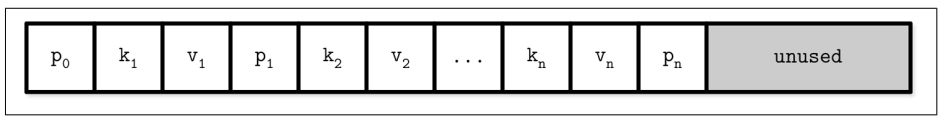

**Slotted Pages**


When storing variable-size records, the main problem is free space management:
reclaiming the space occupied by removed records. If we attempt to put a record of size $n$ into the space previously occupied by the record of size $m$, unless $m = n$ or we can find another record that has a size exactly $m – n$, this space will remain unused.

Similarly, a segment of size $m$ cannot be used to store a record of size $k$ if $k$ is larger than m, so it will be inserted without reclaiming the unused space.

To simplify space management for variable-size records, we can split the page into fixed-size segments. However, we end up wasting space if we do that, too. For example, if we use a segment size of 64 bytes, unless the record size is a multiple of 64, we waste 64 - (n modulo 64) bytes, where n is the size of the inserted record. In other words, unless the record is a multiple of 64, one of the blocks will be only partially filled.


Space reclamation can be done by simply rewriting the page and moving the records around, but we need to preserve record offsets, since out-of-page pointers might be using these offsets. It is desirable to do that while minimizing space waste, too.

To summarize, we need a page format that allows us to:
* Store variable-size records with a minimal overhead.
* Reclaim space occupied by the removed records.
* Reference records in the page without regard to their exact locations.

To efficiently store variable-size records such as strings, binary large objects (BLOBs), etc., we can use an organization technique called **slotted page** (i.e., a page with slots) or **slot directory**. This approach is used
by many databases, for example, **PostgreSQL**.

We organize the page into a collection of slots or cells and split out pointers and cells in two independent memory regions residing on different sides of the page. This means that we only need to reorganize pointers addressing the cells to preserve the order, and deleting a record can be done either by nullifying its pointer or removing it.


A slotted page has a fixed-size header that holds important information about the page and cells. Cells may differ in size and can hold arbitrary data: keys, pointers, data records, etc. 

Let’s see how this approach fixes the problems we stated in the beginning of this section:
* Minimal overhead: the only overhead incurred by slotted pages is a pointer array holding offsets to the exact positions where the records are stored.
* Space reclamation: space can be reclaimed by defragmenting and rewriting the
page.
* Dynamic layout: from outside the page, slots are referenced only by their IDs, so the exact location is internal to the page

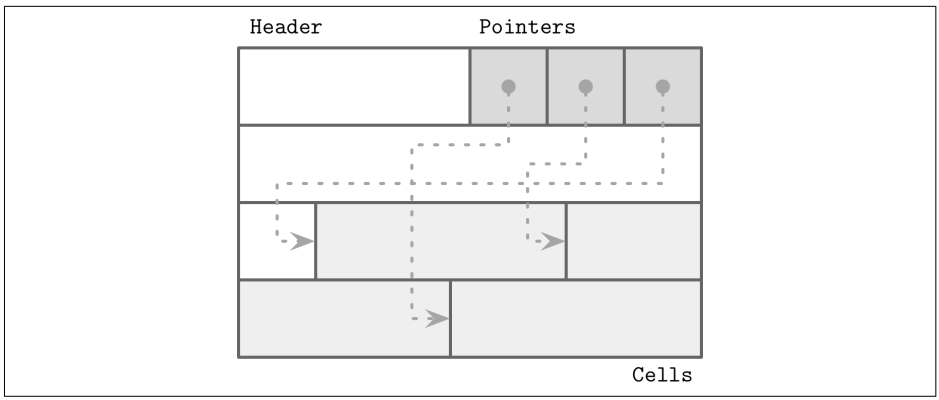

**Cell Layout**


Using flags, enums, and primitive values, we can start designing the cell layout, then combine cells into pages, and compose a tree out of the pages. 

On a cell level, we have a distinction between key and key-value cells. Key cells hold a separator key and a pointer to the page between two neighboring pointers. Key-value cells hold keys and data records associated with them.

We assume that all cells within the page are uniform (for example, all cells can hold either just keys or both keys and values; similarly, all cells hold either fixed-size or variable-size data, but not a mix of both). This means we can store metadata describing cells once on the page level, instead of duplicating it in every cell.

To compose a key cell, we need to know:
* Cell type (can be inferred from the page metadata)
* Key size
* ID of the child page this cell is pointing to
* Key bytes

A variable-size key cell layout might look something like this (a fixed-size one would have no size specifier on the cell level):
```
0                4               8             .....
+----------------+---------------+-------------+
| [int] key_size | [int] page_id | [bytes] key |
+----------------+---------------+-------------+
```
We have grouped fixed-size data fields together, followed by key_size bytes. 

This is not strictly necessary but can simplify offset calculation, since all fixed-size fields can be accessed by using static, precomputed offsets, and we need to calculate the offsets only for the variable-size data.

The key-value cells hold data records instead of the child page IDs. Otherwise, their structure is similar:
* Cell type (can be inferred from page metadata)
* Key size
* Value size
* Key bytes
* Data record bytes

```
0              1                5                  9
+--------------+----------------+------------------+-------------+---------------------+
| [byte] flags | [int] key_size | [int] value_size | [bytes] key | [bytes] data_record |
+--------------+----------------+------------------+-------------+---------------------+
```

You might have noticed the distinction between the offset and page ID here. Since pages have a fixed size and are managed by the page cache, we only need to store the page ID, which is later translated to the actual offset in the file using the lookup table. 

Cell offsets are page-local and are relative to the page start offset: this way we can use a smaller cardinality integer to keep the representation more compact.

**Variable-Size Data**

It is not necessary for the key and value in the cell to have a fixed size. Both the key and value can have a variable size. Their locations can be calculated from the fixedsize cell header using offsets.

To locate the key, we skip the header and read `key_size` bytes. Similarly, to locate the value, we can skip the header plus key_size more bytes and read value_size bytes.

There are different ways to do the same; for example, by storing a total size and calculating the value size by subtraction. It all boils down to having enough information to slice the cell into subparts and reconstruct the encoded data

**Combining Cells into Slotted Pages**


To organize cells into pages, we can use the slotted page technique. We append cells to the right side of the page (toward its end) and keep cell offsets/pointers in the left side of the page.

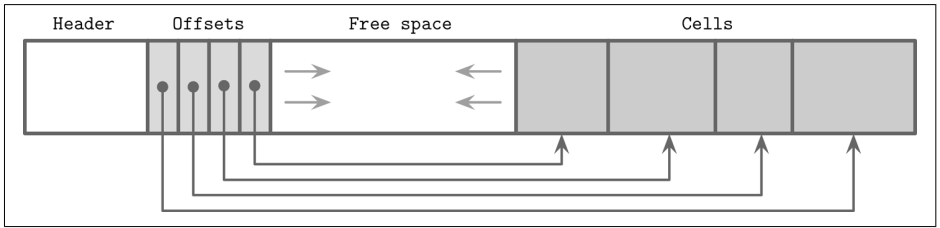

Keys can be inserted out of order and their logical sorted order is kept by sorting cell offset pointers in key order. 

This design allows appending cells to the page with minimal effort, since cells don’t have to be relocated during insert, update, or delete operations.

Let’s consider an example of a page that holds names. Two names are added to the
page, and their insertion order is: Tom and Leslie. As you can see their logical order (in this case, alphabetical), does not match insertion order (order in which they were appended to the page). Cells are laid out in insertion order, but offsets are re-sorted to allow using binary search.

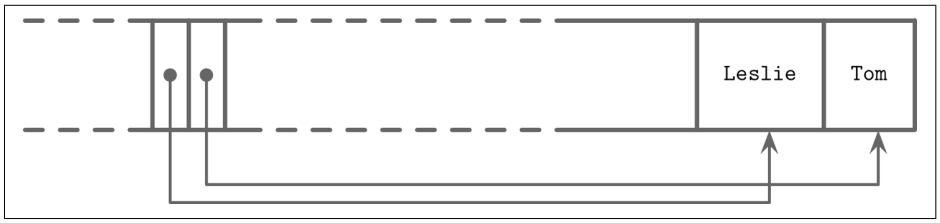

Now, we’d like to add one more name to this page: Ron. New data is appended at the upper boundary of the free space of the page, but cell offsets have to preserve the lexicographical key order: Leslie, Ron, Tom. To do that, we have to reorder cell offsets: pointers after the insertion point are shifted to the right to make space for the new pointer to the Ron cell.

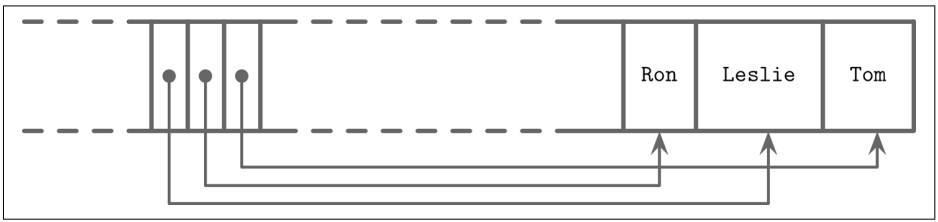

**Managing Variable-Size Data**


Removing an item from the page does not have to remove the actual cell and shift
other cells to reoccupy the freed space. Instead, the cell can be marked as deleted and an in-memory availability list can be updated with the amount of freed memory and a pointer to the freed value. 

The availability list stores offsets of freed segments and their sizes. When inserting a new cell, we first check the availability list to find if
there’s a segment where it may fit.

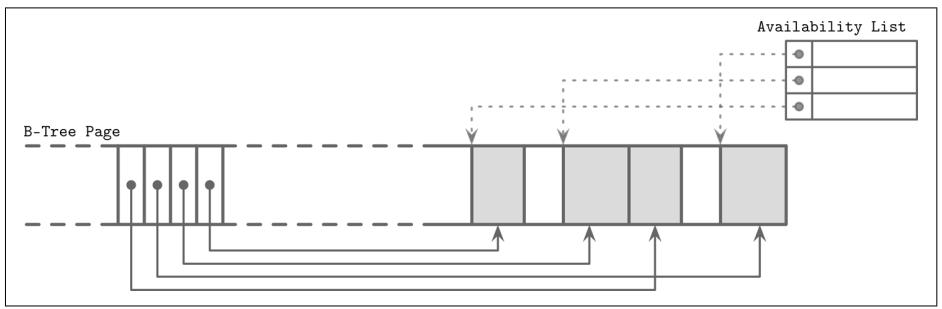

**SQLite** calls unoccupied segments freeblocks and stores a pointer to the first freeblock in the page header. Additionally, it stores a total number of available bytes within the page to quickly check whether or not we can fit a new element into the page after defragmenting it.

Fit is calculated based on the strategy:
* **First fit** This might cause a larger overhead, since the space remaining after reusing the first suitable segment might be too small to fit any other cell, so it will be effectively wasted.
* **Best fit** For best fit, we try to find a segment for which insertion leaves the smallest remainder.


If we cannot find enough consecutive bytes to fit the new cell but there are enough fragmented bytes available, live cells are read and rewritten, defragmenting the page and reclaiming space for new writes. 

If there’s not enough free space even after defragmentation, we have to create an overflow page.

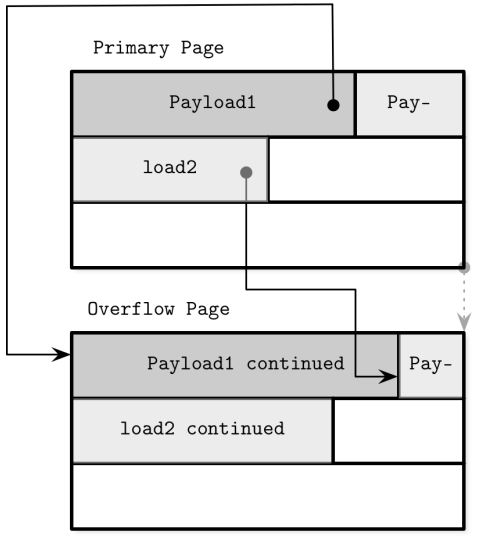

In summary, to simplify B-Tree layout, we assume that each node occupies a single page. 

A page consists of a fixed-size header, cell pointer block, and cells. Cells hold keys and pointers to the pages representing child nodes or associated data records. 

BTrees use simple pointer hierarchies: page identifiers to locate the child nodes in the tree file, and cell offsets to locate cells within the page

**Versioning**


Database systems constantly evolve, and developers work to add features, and to fix bugs and performance issues. As a result of that, the binary file format can change.

Most of the time, any storage engine version has to support more than one serialization format (e.g., current and one or more legacy formats for backward compatibility). To support that, we have to be able to find out which version of the file we’re up against.

This can be done in several ways. For example, **Apache Cassandra** is using version prefixes in filenames. This way, you can tell which version the file has without even opening it. As of version 4.0, a data file name has the na prefix, such as na-1-bigData.db. Older files have different prefixes: files written in version 3.0 have the ma prefix.

Alternatively, the version can be stored in a separate file. For example, **PostgreSQL** stores the version in the PG_VERSION file.

The version can also be stored directly in the index file header. In this case, a part of the header (or an entire header) has to be encoded in a format that does not change between versions. After finding out which version the file is encoded with, we can create a version-specific reader to interpret the contents. Some file formats identify the version using magic numbers.

**Checksumming**


Files on disk may get damaged or corrupted by software bugs and hardware failures. To identify these problems preemptively and avoid propagating corrupt data to other subsystems or even nodes, we can use checksums and cyclic redundancy checks (CRCs).

Some sources make no distinction between cryptographic and noncryptographic
hash functions, CRCs, and checksums. What they all have in common is that they
reduce a large chunk of data to a small number, but their use cases, purposes, and guarantees are different. Checksums provide the weakest form of guarantee and aren’t able to detect corruption in multiple bits. They’re usually computed by using XOR with parity checks or summation.


CRCs can help detect burst errors (e.g., when multiple consecutive bits got corrupted) and their implementations usually use lookup tables and polynomial division. Multibit errors are crucial to detect, since a significant percentage of failures in communication networks and storage devices manifest this way.


Before writing the data on disk, we compute its checksum and write it together with the data. When reading it back, we compute the checksum again and compare it with the written one. If there’s a checksum mismatch, we know that corruption has occurred and we should not use the data that was read.


Since computing a checksum over the whole file is often impractical and it is unlikely we’re going to read the entire content every time we access it, page checksums are usually computed on pages and placed in the page header. This way, checksums can be more robust (since they are performed on a small subset of the data), and the whole file doesn’t have to be discarded if corruption is contained in a single page.